In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
register_matplotlib_converters()
import datetime
import statsmodels

# Ice Cream Production Data

In [2]:
#read data
df_ice_cream = pd.read_csv('ice_cream.csv')

In [3]:
df_ice_cream.head()

,DATE,IPN31152N
0,1972-01-01,59.9622
1,1972-02-01,67.0605
2,1972-03-01,74.2350
3,1972-04-01,78.1120
4,1972-05-01,84.7636


In [4]:
#rename columns to something more understandable
df_ice_cream.rename(columns={'DATE':'date', 'IPN31152N':'production'}, inplace=True)

In [5]:
#convert date column to datetime type
df_ice_cream['date'] = pd.to_datetime(df_ice_cream.date)

In [6]:
#set date as index
df_ice_cream.set_index('date', inplace=True)

In [7]:
#just get data from 2010 onwards
start_date = pd.to_datetime('2010-01-01')
df_ice_cream = df_ice_cream[start_date:]

In [8]:
#show result
df_ice_cream.head()

,production
date,
2010-01-01,91.2895
2010-02-01,110.4994
2010-03-01,127.0971
2010-04-01,132.6468
2010-05-01,134.5576


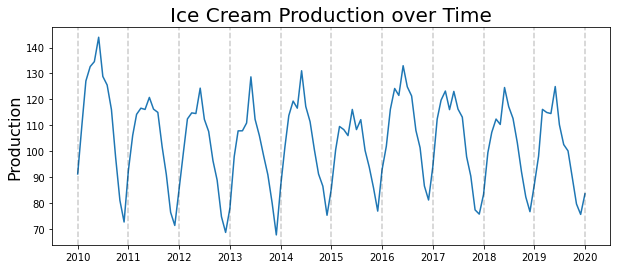

In [9]:
plt.figure(figsize=(10,4))
plt.plot(df_ice_cream.production)
plt.title('Ice Cream Production over Time', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(2010,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [10]:
df_ice_cream.describe()

,production
count,121.000000
mean,103.607036
std,16.914680
min,67.803100
25%,90.998200
50%,107.315200
75%,116.136500
max,143.951900


# ACF

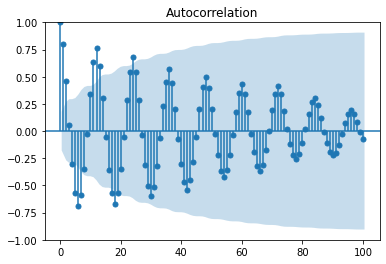

In [11]:
acf_plot = plot_acf(df_ice_cream.production, lags=100)

## Based on decaying ACF, we are likely dealing with an Auto Regressive process

# PACF

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


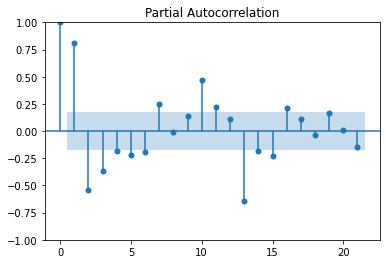

In [12]:
pacf_plot = plot_pacf(df_ice_cream.production)

## Based on PACF, we should start with an Auto Regressive model with lags 1, 2, 3, 10, 13

In [13]:
# Get training and testing sets
train_end = datetime.date(2018,12,1)
test_end = datetime.date(2019,12,1)

train_data= df_ice_cream.production[:train_end]
test_data= df_ice_cream.production[train_end+ datetime.timedelta(days = 1):test_end]

In [27]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data, order=(1,0,1)) # (p,d,q)


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [28]:
model_fit = model.fit()

In [29]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             production   No. Observations:                  119
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -432.792
Date:                Tue, 14 Jun 2022   AIC                            873.585
Time:                        17:48:15   BIC                            884.701
Sample:                    01-01-2010   HQIC                           878.099
                         - 11-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.0216      4.027     25.582      0.000      95.129     110.915
ar.L1          0.7119      0.084      8.460      0.000       0.547       0.877
ma.L1          0.3733      0.139      2.681      0.0


$\hat{y_t} = 103.5743 + 0.80y_{t-1}$

In [17]:
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [18]:
predictions = model_fit.predict(start= pred_start_date, end = pred_end_date)
residual = test_data - predictions

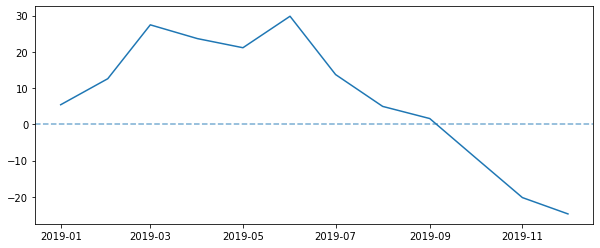

In [24]:
plt.figure(figsize=(10,4))
plt.plot(residual)
plt.axhline(0, linestyle = "--", alpha = 0.6)

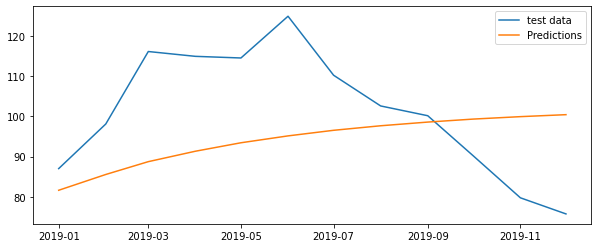

In [26]:
plt.figure(figsize=(10, 4))
plt.plot(test_data)
plt.plot(predictions)
plt.legend(["test data", "Predictions"])

In [20]:
prediction_rolling = pd.Series()

for end_date in test_data.index:
    train_data = df_ice_cream.production[:end_date-datetime.timedelta(days=1)]
    model = ARIMA(train_data, order=(1,0,0))
    model_fit = model.fit()
    pred = model_fit.predict(end_date)
    prediction_rolling.loc[end_date] = pred.loc[end_date]

C:\Users\vaibhav\AppData\Local\Temp\ipykernel_15968\1441391170.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prediction_rolling = pd.Series()
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency informat

In [21]:
residuals_rolling = test_data - prediction_rolling

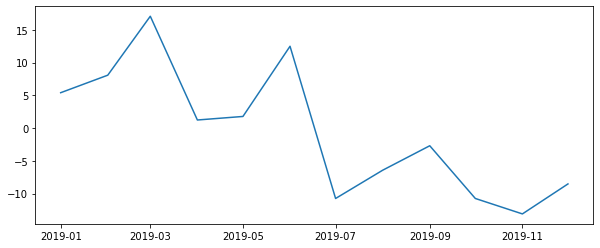

In [22]:
plt.figure(figsize=(10, 4))
plt.plot(residuals_rolling)

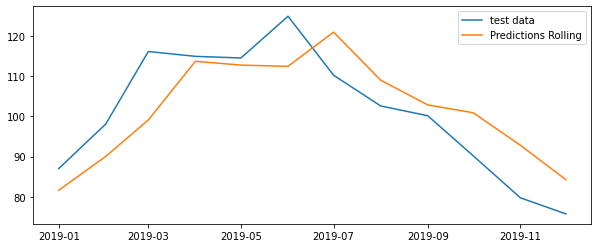

In [25]:
plt.figure(figsize=(10, 4))
plt.plot(test_data)
plt.plot(prediction_rolling)
plt.legend(["test data", "Predictions Rolling"])